In [1]:
from typing import List, Literal

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.datasets import make_blobs

from utils import visualize_clusters

In [2]:
student_id = 994023037
np.random.seed(student_id)

### Load Data

In [3]:
X, y = make_blobs(
    n_samples=1000,
    n_features=8,
    centers=5,
    random_state=student_id
)

In [4]:
split_line = 0.8
q1 = int(np.ceil(X.shape[0] * split_line))
x_train, y_train = X[0:q1, :], y[0:q1]
x_test, y_test = X[q1:, :], y[q1:]

### Modeling

In [5]:
class KMeans :
    def __init__(
        self,
        n_clusters:int,
        centroid_init:List[Literal["kmeans++", "random"]] = "random",
        max_iter:int = 10,
    ) -> None:
        self.n_clusters = n_clusters
        self.centroid_init = centroid_init
        self.max_iter = max_iter
    
    @staticmethod
    def get_distance(x1, x2) :
        # Calculating the Distance
        if x1.ndim == 1 and x2.ndim == 1 :
            return np.linalg.norm(x1 - x2)
        else :
            return np.linalg.norm(x1 - x2, axis=1)
    
    def _set_centroids(self) :
        if self.centroids is None : # initializing the centroids for the first time
            if self.centroid_init == "random" :
                chosen_centroids_index = np.random.randint(0, self.n_samples+1, size=self.n_clusters)
                self.centroids = self.X[chosen_centroids_index]
            elif self.centroid_init == "kmeans++" :
                self.centroids = []
                first_centroid = self.X[np.random.randint(0, self.n_samples+1, size=1)].reshape(self.n_features,)
                self.centroids.append(first_centroid)
                for index in range(self.n_clusters-1) :
                    max_distance = 0
                    for sample in self.X :
                        closest_centroid = self.centroids[np.argmin(
                            KMeans.get_distance(
                                sample,
                                np.array(self.centroids).reshape(-1, self.n_features)
                            )
                        )]
                        distance = KMeans.get_distance(
                            sample,
                            closest_centroid
                        )
                        if max_distance < distance :
                            new_centroid_candidate = sample
                            max_distance = distance
                    self.centroids.append(new_centroid_candidate)
                self.centroids = np.array(self.centroids)

        else :
            for index in range(self.n_clusters) :
                new_centroid = self.X[self.clusters == index].mean(axis=0)
                self.centroids[index] = new_centroid

    def fit(self, x) :
        self.X = x
        self.n_samples, self.n_features = x.shape
        self.centroids = None 
        self.clusters = np.empty(shape=(self.n_samples,))

        for _ in range(self.max_iter) :
            self._set_centroids()
            prev_clusters = self.clusters.copy()
            for index, sample in enumerate(self.X) :
                distance = self.get_distance(sample, self.centroids) # distance from eah centroid
                closest_centroid_index = np.argmin(distance)
                self.clusters[index] = closest_centroid_index
            if np.equal(prev_clusters, self.clusters).all() : # check if anything has changed since the last update
                break

    def predict(self, x) :
        '''Predicts the closest Centroid to each sample
        '''
        return np.argmin([KMeans.get_distance(x, centroid) for centroid in self.centroids], axis=0)

    def evaluate(self, X,
        labels,
        method:List[Literal["Silhouette", "Calinski", "wcss"]]
    ) :
        '''
        Silhouette Score :  
            This metric ranges from -1 to 1, the higher the value, the better the clustering\n
            s(i) = (b(i) - a(i)) / max(a(i), b(i)) \n

        Calinski-Harabasz Index  :
            Measures ratio of dispersion between clusters to dispersion within clusters.    
            The higher the value, the better the clustering\n
            score = (trace(B) / (k - 1)) / (trace(W) / (n - k))\n

        WCSS :  
            Within-Cluster Sum of Squares (WCSS)  
            measures the sum of squared distances between each data point and the centroid of its assigned cluster\n
        '''
        if method == "Silhouette":
            silhouette_coeffs = []
            
            for i in range(len(X)):
                cluster_i = X[labels == labels[i]]
                a = np.sum(np.sqrt(np.sum((X[i] - cluster_i)**2, axis=1))) / (len(cluster_i) - 1)
                
                b = np.inf
                for j in range(self.n_clusters):
                    if j != labels[i]:
                        cluster_j = X[labels == j]
                        b = min(b, np.sum(np.sqrt(np.sum((X[i] - cluster_j)**2, axis=1))) / len(cluster_j))
                
                silhouette_coeffs.append((b - a) / max(a, b))
            
            return np.mean(silhouette_coeffs)
        
        elif method == "Calinski":            
            cluster_means = []
            for i in range(self.n_clusters):
                cluster_means.append(np.mean(X[labels == i], axis=0))
            
            overall_mean = np.mean(X, axis=0)
            
            B = 0
            for i in range(self.n_clusters):
                cluster_i = X[labels == i]
                B += len(cluster_i) * np.sum((cluster_means[i] - overall_mean)**2)
            
            W = 0
            for i in range(self.n_samples):
                W += np.sum((X[i] - cluster_means[int(labels[i])])**2)
            
            return (B / (self.n_clusters - 1)) / (W / (self.n_samples - self.n_clusters))
        
        elif method == "wcss":
            cluster_means = np.array([X[labels == label].mean(axis=0) for label in np.arange(self.n_clusters)])
            labels = labels.astype(int)
            wcss = np.sum(np.sum((X - cluster_means[labels])**2, axis=1))
            
            return wcss

In [6]:
model = KMeans(
    n_clusters=5,
    centroid_init="kmeans++",
    # centroid_init="random",
    max_iter=10,
)
model.fit(X)

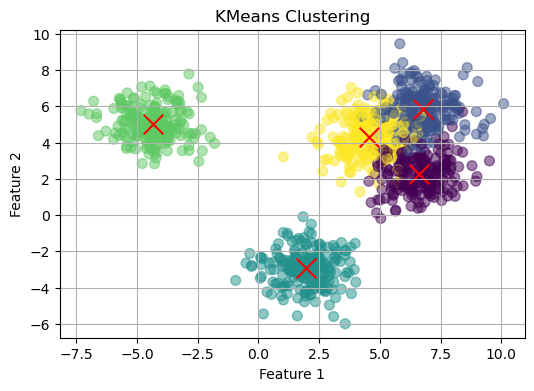

In [7]:
visualize_clusters(X, model.clusters, model.centroids)

In [8]:
# # Comparing to the Kmeans from Sklean
# from sklearn.cluster import KMeans as KMeans2

# tmp = KMeans2(5, init="k-means++")
# tmp.fit(X)

# visualize_clusters(X, tmp.predict(X), tmp.cluster_centers_)

### Evaluation

for evaluation, we use 3 methods<br>First one is **Silhouette score** which is a number between -1 to 1, higher score shows better performance  
the formula for calculating this metric is :  
`s(i) = (b(i) - a(i)) / max(a(i), b(i))`
<br></br>
The second method for evaluating the performance of the model is **Calinski-Harabasz Index**, like the previous metric, higher values  
shows better performance.  
the formula for calculating this metric is :  
`score = (trace(B) / (k - 1)) / (trace(W) / (n - k))`  
<br>
The last one is **WCSS**, which measures the sum of squared distances between each data point and the centroid of its assigned cluster.

In [9]:
model.evaluate(X, model.clusters, method="Silhouette")

0.7213085535194689

Silhouette score shows good performance score

In [10]:
model.evaluate(X, model.clusters, method="Calinski")

5799.698892878035

In [11]:
model.evaluate(X, model.clusters, method="wcss")

7888.566240833485

In [12]:
# # Comparing to Sklearn functions, which results in the same output
# from sklearn.metrics import silhouette_score, calinski_harabasz_score

# print(silhouette_score(X, model.clusters))
# print(calinski_harabasz_score(X, model.clusters))

the centroids are more clear if we use less features :

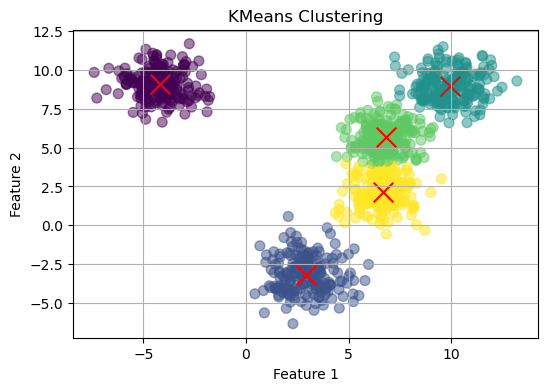

In [13]:
X_2, y_2 = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=5,
    random_state=student_id
)
model2 = KMeans(
    n_clusters=5,
    centroid_init="kmeans++",
    max_iter=10,
)
model2.fit(X_2)

visualize_clusters(X_2, model2.clusters, model2.centroids)

### Test different values of n_clusters

In [14]:
data = X
n_clusters = [4, 5, 6, 7]

# data = X_2
# n_clusters = [3, 4, 5, 6]


In [15]:
results = []
for n in n_clusters :
    model = KMeans(
        n_clusters=n,
        centroid_init="kmeans++",
        max_iter=10,
    )
    model.fit(data)
    results.append([model.clusters, model.centroids])

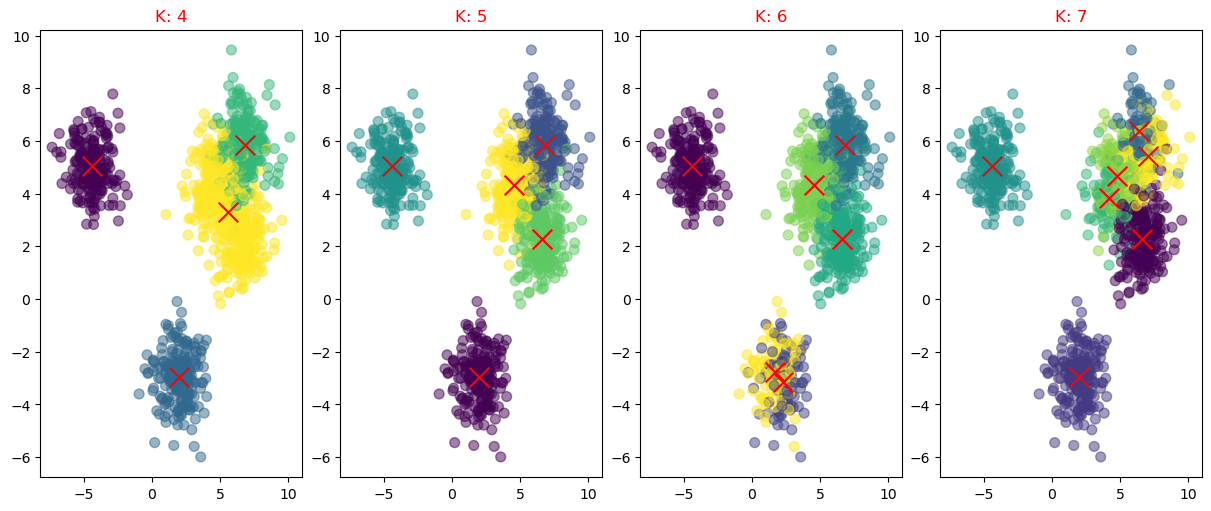

In [16]:
fig, ax = plt.subplots(1, len(n_clusters), figsize=(12, 5), layout="constrained")
for index, result in zip(range(len(n_clusters)), results) :
    labels, centroid = result
    ax[index].scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
    ax[index].scatter(centroid[:, 0], centroid[:, 1], c='red', marker='x', s=200)
    ax[index].set_title(f'K: {n_clusters[index]}', color="red")
    # ax[index].grid(True)

as we expected, the K=5 seems like the best choice 

### Choosing the best value for K

for that, we are going to use **elbow method** and **Silhouette** score

In [17]:
data = X
# data = X_2

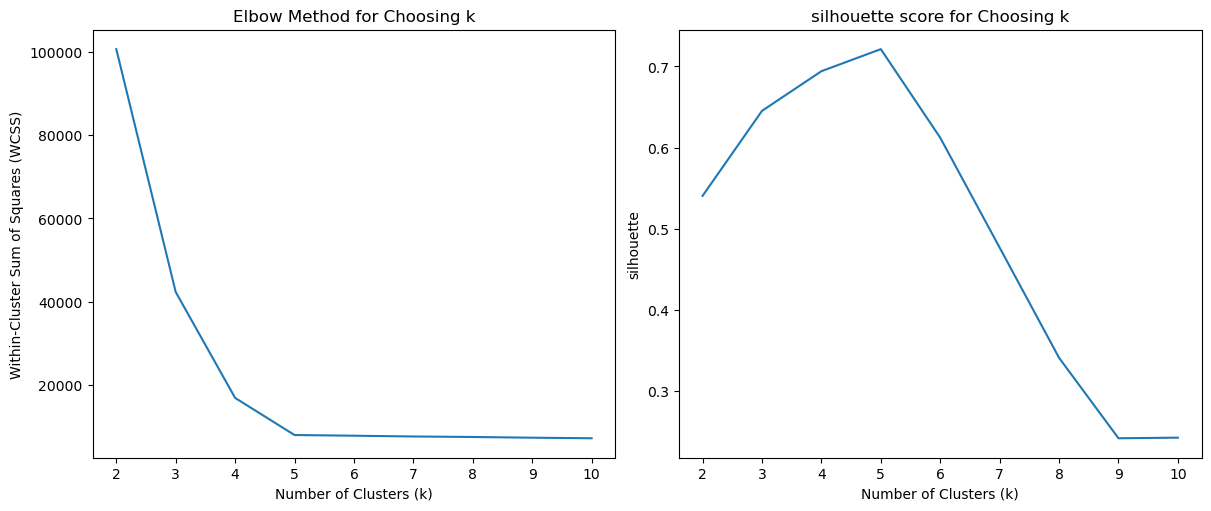

In [18]:
wcss_values = []
silhouette_values = []

for k in range(2, 11):
    model = KMeans(
        n_clusters=k,
        centroid_init="kmeans++",
        max_iter=10,
    )
    model.fit(data)
    wcss_values.append(model.evaluate(data, model.clusters, method="wcss"))
    silhouette_values.append(model.evaluate(data, model.clusters, method="Silhouette"))


# Plot WCSS 
fig, ax = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

ax[0].plot(range(2, 11), wcss_values)
ax[0].set_xlabel("Number of Clusters (k)")
ax[0].set_ylabel("Within-Cluster Sum of Squares (WCSS)")
ax[0].set_title("Elbow Method for Choosing k")

ax[1].plot(range(2, 11), silhouette_values)
ax[1].set_xlabel("Number of Clusters (k)")
ax[1].set_ylabel("silhouette")
ax[1].set_title("silhouette score for Choosing k")

plt.show()

**Elbow Method** -> the best point is K=5  
**Silhouette Score** -> the highest score belongs to K=5  
so as we expected, the best K is 5

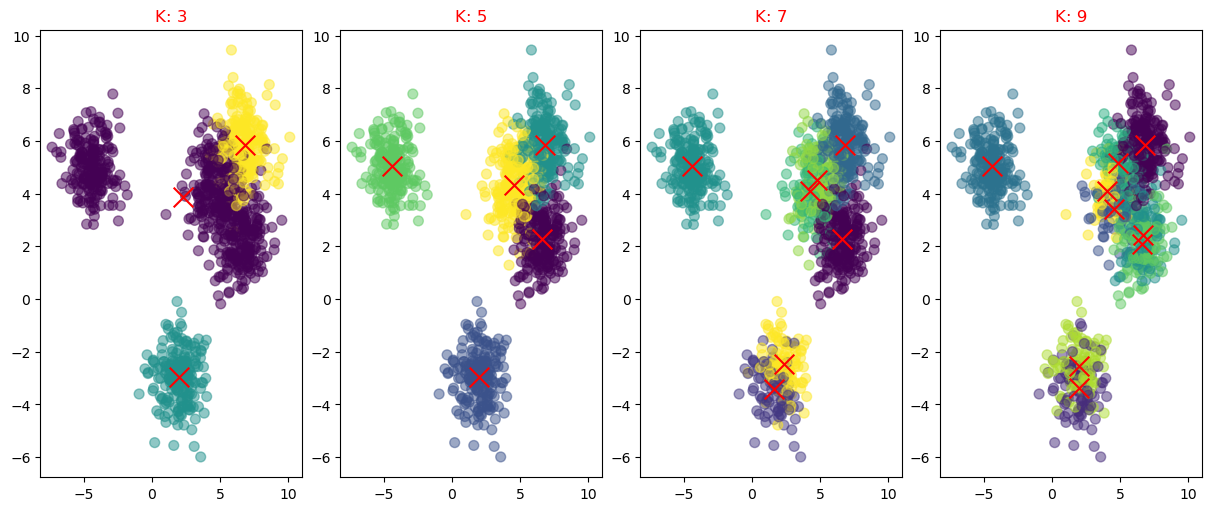

In [19]:
n_clusters = [3, 5, 7, 9]
results = []
for n in n_clusters :
    model = KMeans(
        n_clusters=n,
        centroid_init="kmeans++",
        max_iter=10,
    )
    model.fit(data)
    results.append([model.clusters, model.centroids])

fig, ax = plt.subplots(1, len(n_clusters), figsize=(12, 5), layout="constrained")
for index, result in zip(range(len(n_clusters)), results) :
    labels, centroid = result
    ax[index].scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
    ax[index].scatter(centroid[:, 0], centroid[:, 1], c='red', marker='x', s=200)
    ax[index].set_title(f'K: {n_clusters[index]}', color="red")
    # ax[index].grid(True)

so the best centroids are :

In [20]:
# Best centroids 
model = KMeans(
    n_clusters=5,
    centroid_init="kmeans++",
    max_iter=10,
)
model.fit(X)
model.centroids

array([[-4.35663868,  5.03927727, -3.56503341, -1.20181117,  7.47546709,
        -5.72166813,  0.2925639 ,  3.12638538],
       [ 1.97271188, -2.94636906, -3.54357022,  9.68719614, -7.76290318,
        -9.25266157, -8.94120501, -4.91963402],
       [ 6.78033102,  5.84049953, -4.32490498,  9.00056835,  9.90621538,
         8.91373268,  3.07573821, -3.16413338],
       [ 4.54368174,  4.33263435, -8.89179188,  0.30102288,  3.04816411,
        -2.47251499,  6.40981761,  9.03024782],
       [ 6.62559469,  2.26781186, -9.16980445, -1.22369572,  0.73047073,
        -2.78200284,  0.58342944,  2.79963064]])

### Comparing Kmeans++ and random initialization

In [21]:
data = X

m1 = KMeans(
    n_clusters=5,
    centroid_init="kmeans++",
    max_iter=10,
)
m1.fit(data)

m2 = KMeans(
    n_clusters=5,
    centroid_init="random",
    max_iter=10,
)
m2.fit(data)

Text(0.5, 1.0, 'random')

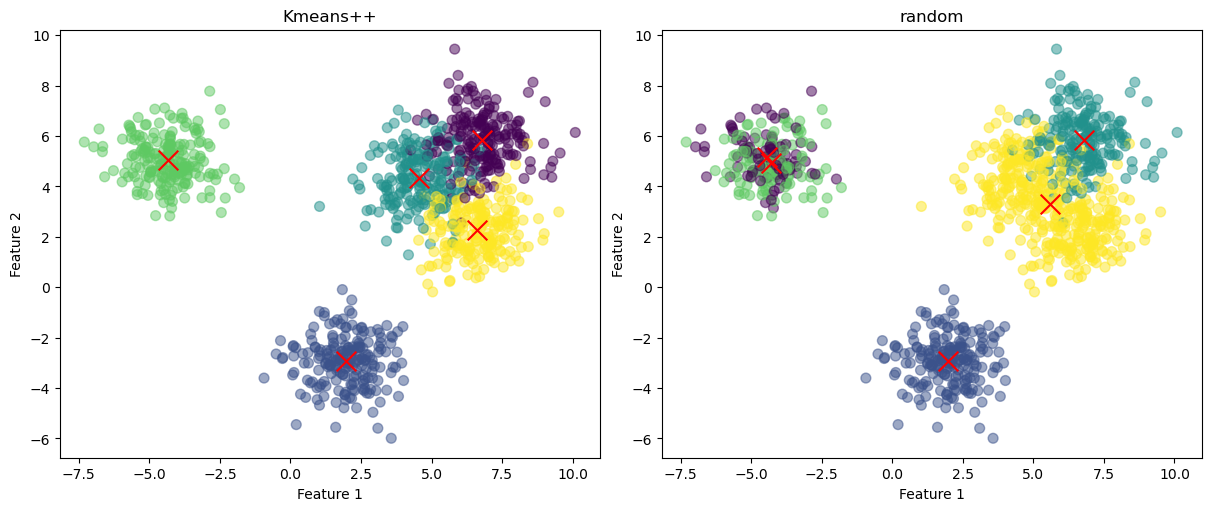

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

ax[0].scatter(data[:, 0], data[:, 1], c=m1.clusters, cmap='viridis', s=50, alpha=0.5)
ax[0].scatter(m1.centroids[:, 0], m1.centroids[:, 1], c='red', marker='x', s=200)
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")
ax[0].set_title("Kmeans++")

ax[1].scatter(data[:, 0], data[:, 1], c=m2.clusters, cmap='viridis', s=50, alpha=0.5)
ax[1].scatter(m2.centroids[:, 0], m2.centroids[:, 1], c='red', marker='x', s=200)
ax[1].set_xlabel("Feature 1")
ax[1].set_ylabel("Feature 2")
ax[1].set_title("random")

if we run the second model ( with random initialization ) multiple times, the results change and might get better.  
now lets compare these 2 methods:  

**kmeans++**  
- Cons
    - The k-means++ algorithm can be slightly slower than random initialization, as it needs to calculate the distances to the existing
        centroids and sample the new centroids based on the probabilities.
    - The k-means++ algorithm may still converge to a local optimum, just like the standard k-means algorithm.
- Pros
    - The k-means++ initialization helps to spread out the initial centroids, reducing the likelihood of converging to a poor local optimum.
    - The k-means++ initialization generally leads to better clustering results compared to random initialization, as the initial
        centroids are more evenly distributed across the data.
    - The k-means++ algorithm is deterministic, meaning that running the algorithm multiple times with the same data will yield the same
        clustering results (unlike random initialization).  
<br></br>

**random init**
- Cons
    - The random initialization of centroids can lead to poor clustering results, as the initial centroids may be close to each other
        or in regions with sparse data.
    - Running the k-means algorithm with random initialization multiple times may yield different clustering results, as the algorithm
        can converge to different local optima.
- Pros
    - The random initialization is simpler and faster than the k-means++ algorithm, as it does not require the additional computation
        to determine the initial centroids.
    - For some datasets, the random initialization may still lead to satisfactory clustering results, especially if the clusters
        are well-separated.
    - The random initialization can be useful for exploring the solution space and potentially finding better clustering results
        than the k-means++ initialization, especially if the k-means++ initialization gets stuck in a local optimum.